# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
import numpy as np
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
#load_dict_from_json, read_file_name, validate_distance_array,
cost_fn_fact, cost_fn_tensor, hot_start, hot_start_list_to_string)

#from modules.config import NETWORK_DIR, DATA_SOURCES, GRAPH_DIR
from modules.config import GRAPH_DIR
from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model)

from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training)

Set up constants:

In [2]:
LOCATIONS = 8                       #locations in problem
DECODING_FORMULATION = 'original'   #decoding formulation
                                    #options: 'original', 'new'
GRAY = False                        #gray code  
STD_DEV = 0.5                       #standard deviation for weight randomization
NUM_EPOCHS = 50                     #number of epochs for training
NUM_LAYERS = 2                      #number of layers in the mode
LR = 0.0001                         #Learning rate
VERBOSE = False                     #controls how much output the model produces
BATCH_SIZE = 64                     #size of input tensor.  Reduces randomness
MOMENTUM = 0.001                    #momentum for optimizer
WEIGHT_DECAY = 0.0002               #importance of L2 regularization in optimiser
OPTIMIZER = 'SGD'                   #optimizer to use
                                    #options: 'Adam', 'SGD', 'RMSprop
     

Read in data and report on data read:

In [3]:
"""sources_filename = Path(NETWORK_DIR).joinpath(DATA_SOURCES)
data_source_dict = load_dict_from_json(sources_filename)
filename = read_file_name(str(LOCATIONS), data_source_dict)
filepath = Path(NETWORK_DIR).joinpath(filename)
best_dist = data_source_dict[str(LOCATIONS)]['best']
print(f'Data will be read from filename {filepath}.  It is known that the shortest distance is {best_dist}.')""""No push"

"sources_filename = Path(NETWORK_DIR).joinpath(DATA_SOURCES)\ndata_source_dict = load_dict_from_json(sources_filename)\nfilename = read_file_name(str(LOCATIONS), data_source_dict)\nfilepath = Path(NETWORK_DIR).joinpath(filename)\nbest_dist = data_source_dict[str(LOCATIONS)]['best']\nprint(f'Data will be read from filename {filepath}.  It is known that the shortest distance is {best_dist}.')No push"

Read in and validate distance array:

In [4]:
"""distance_array = np.genfromtxt(filepath)
validate_distance_array(distance_array, LOCATIONS)"""

'distance_array = np.genfromtxt(filepath)\nvalidate_distance_array(distance_array, LOCATIONS)'

Read in data:


In [5]:
distance_array, best_dist = find_distances_array(LOCATIONS, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_8_locs.txt.
It is known that the shortest distance is 277.2


Evaluate cost function and clear cache:

In [6]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [7]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [8]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 14 qubits needed for 8 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [9]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.2f}, compared to a best distance of {best_dist:.2f}.')

The hot start location list is [0, 3, 5, 4, 1, 6, 7, 2]
This is equivalent to a binary list: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
bin_hot_start_list_tensor = tensor([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]])
The hot start distance is 315.80, compared to a best distance of 277.20.


Set up input as repeated hot start tensor calculated above:

In [10]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(BATCH_SIZE, 1).requires_grad_(True)

Set up model with gradient required:

In [11]:

model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 420 parameters in total, of which 420 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

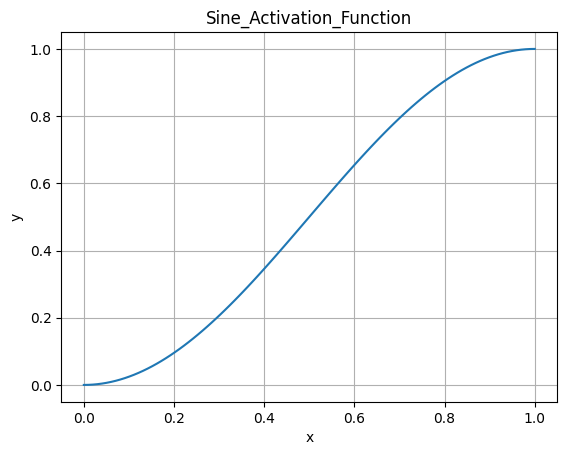

In [13]:
plot_sine_activation()

Print out model details including graph

Output = 499.16094970703125
{'fc1.weight': Parameter containing:
tensor([[ 1.0666e+00, -7.5364e-01, -1.8293e-01, -1.2873e+00, -3.5659e-01,
          3.7751e-01, -4.8205e-01,  6.9563e-01,  5.1447e-02,  3.0075e-01,
          1.1125e+00,  2.9161e-01, -9.4483e-01,  8.1320e-01],
        [-6.2414e-01,  1.0291e+00, -1.8907e-01, -3.0439e-01,  6.8137e-02,
          6.4478e-01,  2.7797e-01,  7.8739e-02, -2.5552e-01,  4.7972e-01,
          7.5407e-01, -7.7668e-01, -2.2956e-01, -2.5620e-01],
        [-2.5598e-01, -3.0139e-01,  2.4740e+00,  7.1838e-01,  5.7327e-01,
          8.9165e-02, -3.7289e-01, -1.0527e+00,  6.0154e-02, -5.1570e-03,
         -2.9301e-01, -2.8486e-01,  4.1898e-01, -2.0210e-01],
        [-8.0396e-03, -3.5451e-02, -4.7915e-01,  8.0447e-01,  9.9923e-01,
          6.0543e-01, -3.2667e-01, -2.2302e-01,  9.8005e-01, -4.2773e-01,
         -3.3729e-01,  6.1054e-01,  1.0570e-01, -9.0965e-01],
        [-1.5291e-01, -7.4041e-01,  4.1292e-01, -3.6857e-01,  8.2753e-01,
          2.2376e-01,

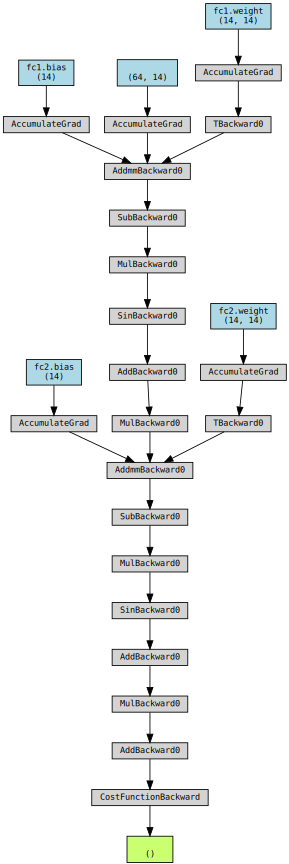

In [14]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

In [15]:
"""target = torch.tensor(0.0, requires_grad=True)
criterion = nn.L1Loss()
if OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), momentum=MOMENTUM, lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
else:
    raise ValueError(f'Optimizer {OPTIMIZER} not recognized')"""

"target = torch.tensor(0.0, requires_grad=True)\ncriterion = nn.L1Loss()\nif OPTIMIZER == 'Adam':\n    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)\nelif OPTIMIZER == 'SGD':\n    optimizer = torch.optim.SGD(model.parameters(), momentum=MOMENTUM, lr=LR, weight_decay=WEIGHT_DECAY)\nelif OPTIMIZER == 'RMSprop':\n    optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)\nelse:\n    raise ValueError(f'Optimizer {OPTIMIZER} not recognized')"

In [16]:
target, criterion, optimizer = get_ready_to_train(model, OPTIMIZER, LR, WEIGHT_DECAY, momentum = MOMENTUM)

In [17]:
"""epoch_history = []
loss_history = []
epoch_lowest_cost_found = 0
for epoch in range(NUM_EPOCHS):
    epoch_history.append(epoch)
    model_output = model(my_input)
    loss = criterion(model_output, target)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    if float(model_output ) < lowest_cost:
        lowest_cost = float(loss)
        epoch_lowest_cost_found = epoch
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Cost: {loss:.3f}, Lowest Cost to date =  {lowest_cost:.3f}")
        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f'Epoch {epoch}, {name} grad: {param.grad.norm():.2f}')
            else:
                print(f'Epoch {epoch}, {name} grad is None')

    optimizer.zero_grad()

print(f'The lowest cost found was {lowest_cost:.3f} at epoch {epoch_lowest_cost_found}.')
print(f'The best known cost is {best_dist:.3f} and the hot start cost was {float(distance_tensor):.3f}.')"""


'epoch_history = []\nloss_history = []\nepoch_lowest_cost_found = 0\nfor epoch in range(NUM_EPOCHS):\n    epoch_history.append(epoch)\n    model_output = model(my_input)\n    loss = criterion(model_output, target)\n    loss_history.append(float(loss))\n    loss.backward()\n    optimizer.step()\n    if float(model_output ) < lowest_cost:\n        lowest_cost = float(loss)\n        epoch_lowest_cost_found = epoch\n    if epoch % 50 == 0:\n        print(f"Epoch {epoch}, Cost: {loss:.3f}, Lowest Cost to date =  {lowest_cost:.3f}")\n        # Check gradients\n        for name, param in model.named_parameters():\n            if param.grad is not None:\n                print(f\'Epoch {epoch}, {name} grad: {param.grad.norm():.2f}\')\n            else:\n                print(f\'Epoch {epoch}, {name} grad is None\')\n\n    optimizer.zero_grad()\n\nprint(f\'The lowest cost found was {lowest_cost:.3f} at epoch {epoch_lowest_cost_found}.\')\nprint(f\'The best known cost is {best_dist:.3f} and the h

In [ ]:
lowest_cost, epoch_lowest_cost, epoch_hist, loss_hist = train_model(NUM_EPOCHS,
                                                                    model, 
                                                                    my_input, 
                                                                    target, 
                                                                    criterion,
                                                                    optimizer,
                                                                    print_results=True)

TypeError: train_model() missing 1 required positional argument: 'lowest_cost'

Plot loss ratio by epoch:

In [ ]:
plot_model_training(epoch_hist, loss_hist)

In [ ]:
#for layer in model.children():
#    if isinstance(layer, nn.Linear):
#        print('weight:', layer.weight)
#        print('bias:', layer.bias)